In [13]:
!pip install casadi
from IPython.display import clear_output
import os

import numpy as np
import casadi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
import time

os.makedirs('images',exist_ok=True)
if os.name == 'nt':
    plt.rcParams['font.family'] = 'MS Gothic'
elif os.name == 'posix':
    !pip install japanize-matplotlib


clear_output()

In [14]:
g = 9.81 #重力加速度
M = 1 #台車の質量
m = 0.2 #振子の質量
l = 1 #振子の長さ

nu = 1 #制御変数の次元
nx = 4 #状態変数の次元

# コスト関数の重み
Q = casadi.diag([2.5,10,0.01,0.01])
Q_f = casadi.diag([2.5,10,0.01,0.01])
R = casadi.diag([0.1])

# 予測ホライズン等
T = 3
K = 60
dt = T/K

# 制約条件
x_lb = [-1,-np.inf,-np.inf,-np.inf]
x_ub = [1,np.inf,np.inf,np.inf]
u_lb = [-15]
u_ub = [15]

# 目標
x_ref = casadi.DM([0,0,0,0])
u_ref = casadi.DM([0])

total_dss = nx + nu*K
total_dms = nx*(K+1) + nu*K

In [15]:
def make_f():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    x = states[0]
    theta = states[1]
    x_dot = states[2]
    theta_dot = states[3]
    F = ctrls[0]

    sin = casadi.sin(theta)
    cos = casadi.cos(theta)
    det = M+m*sin**2

    x_ddot = (-m*l*sin*theta_dot**2+m*g*sin*cos+F)/det
    theta_ddot = (-m*l*sin*cos*theta_dot**2+(M+m)*g*sin+F*cos)/(l*det)

    states_dot = casadi.vertcat(x_dot,theta_dot,x_ddot,theta_ddot)

    f = casadi.Function("f",[states,ctrls],[states_dot],['x','u'],['x_dot'])
    return f

def make_RK4():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    f = make_f()

    r1 = f(x=states,u=ctrls)["x_dot"]
    r2 = f(x=states+dt*r1/2,u=ctrls)["x_dot"]
    r3 = f(x=states+dt*r2/2,u=ctrls)["x_dot"]
    r4 = f(x=states+dt*r3,u=ctrls)["x_dot"]

    states_next = states + dt*(r1+2*r2+2*r3+r4)/6

    F_RK4 = casadi.Function("RK4",[states,ctrls],[states_next],["x","u"],["x_next"])
    return F_RK4

def make_integrator():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    f = make_f()
    ode = f(x=states, u=ctrls)["x_dot"]

    dae = {"x":states,"p":ctrls,"ode":ode}

    I = casadi.integrator("I","cvodes",dae,0,dt)
    return I

def compute_stage_cost(x,u):
    x_diff = x - x_ref
    u_diff = u - u_ref
    cost = (casadi.dot(Q@x_diff,x_diff) + casadi.dot(R@u_diff,u_diff)) / 2
    return cost

def compute_terminal_cost(x):
    x_diff = x - x_ref
    cost = casadi.dot(Q_f@x_diff,x_diff) / 2
    return cost

In [16]:
def make_nlp_dss():
    F_RK4 = make_RK4()

    U = [casadi.SX.sym(f"u_{k}",nu) for k in range(K)]
    x_init = casadi.SX.sym("x_init",nx)
    G = []

    J = 0
    x_tmp = x_init
    for k in range(K):
        J += compute_stage_cost(x_tmp,U[k]) * dt
        x_tmp = F_RK4(x=x_tmp,u=U[k])["x_next"]
        G.append(x_tmp)
    J += compute_terminal_cost(x_tmp)
    
    option = {'print_time':False,'ipopt':{'print_level':0}}
    nlp = {"x":casadi.vertcat(x_init,*U),
           "f":J, "g":casadi.vertcat(*G)}
    S = casadi.nlpsol("S","ipopt",nlp,option)
    return S

def make_nlp_dms():
    F_RK4 = make_RK4()

    U = [casadi.SX.sym(f"u_{k}",nu) for k in range(K)]
    X = [casadi.SX.sym(f"x_{k}",nx) for k in range(K+1)]
    G = []

    J = 0
    for k in range(K):
        J += compute_stage_cost(X[k],U[k]) * dt
        eq = X[k+1] - F_RK4(x=X[k],u=U[k])["x_next"]
        G.append(eq)
    J += compute_terminal_cost(X[-1])

    option = {'print_time':False,'ipopt':{'print_level':0}}
    nlp = {"x":casadi.vertcat(*X,*U),"f":J,"g":casadi.vertcat(*G)}
    S = casadi.nlpsol("S","ipopt",nlp,option)
    return S

In [17]:
def compute_optimal_control_dss(S,x_init,x0):
    x_init = x_init.full().ravel().tolist()
    
    lbx = x_init + u_lb*K
    ubx = x_init + u_ub*K
    lbg = x_lb*K
    ubg = x_ub*K

    res = S(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,x0=x0)
    
    offset = nx
    x0 = res["x"]
    u_opt = x0[offset:offset+nu]
    return u_opt, x0
    
def compute_optimal_control_dms(S,x_init,x0):
    x_init = x_init.full().ravel().tolist()
    
    lbx = x_init + x_lb*K + u_lb*K
    ubx = x_init + x_ub*K + u_ub*K
    lbg = [0]*nx*K
    ubg = [0]*nx*K

    res = S(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,x0=x0)
    
    offset = nx*(K+1)
    x0 = res["x"]
    u_opt = x0[offset:offset+nu]
    return u_opt, x0

# Direct Single Shooting

In [18]:
S_dss = make_nlp_dss()

x_init = casadi.DM([0,np.pi,0,0]) # 初期値
x0 = casadi.DM.zeros(total_dss)

time_s = time.perf_counter()
_,x0 = compute_optimal_control_dss(S_dss,x_init,x0)
time_e = time.perf_counter()
print(f"[*] method: direct single shooting, elapsed time: {time_e-time_s:.4f}s")

[*] method: direct single shooting, elapsed time: 2.0847s


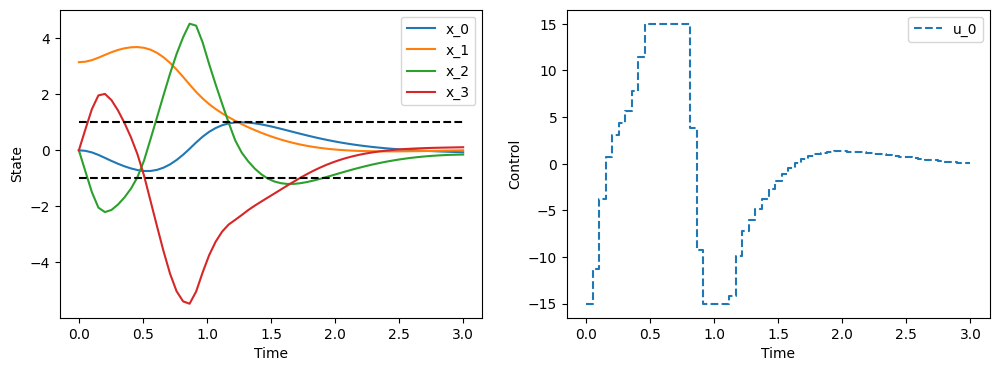

In [19]:
F_RK4 = make_RK4()
U = np.array(x0[nx:]).reshape(K,nu)
X = [x_init]
for i in range(K-1):
    x_tmp = F_RK4(x=X[-1],u=U[i])["x_next"]
    X.append(x_tmp)
X = np.array(X)
t_eval = np.linspace(0,T,K)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
for k in range(nx):
    plt.plot(t_eval,X[:,k],label=f"x_{k}")
plt.legend()
plt.hlines(y=x_lb[0],xmin=0,xmax=T,colors="black", linestyle='dashed')
plt.hlines(y=x_ub[0],xmin=0,xmax=T,colors="black", linestyle='dashed')
plt.xlabel("Time")
plt.ylabel("State")

plt.subplot(1,2,2)
for k in range(nu):
    plt.step(t_eval,U[:,k],linestyle="--",label=f"u_{k}")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Control")

plt.savefig("images/chap6_single_shooting_cartpole.png")
plt.show()

# Direct Multiple Shooting

In [20]:
S_dms = make_nlp_dms()

x_init = casadi.DM([0,np.pi,0,0]) # 初期値
x0 = casadi.DM.zeros(total_dms)

time_s = time.perf_counter()
_,x0 = compute_optimal_control_dms(S_dms,x_init,x0)
time_e = time.perf_counter()
print(f"[*] method: direct multiple shooting, elapsed time: {time_e-time_s:.4f}s")

[*] method: direct multiple shooting, elapsed time: 0.3093s


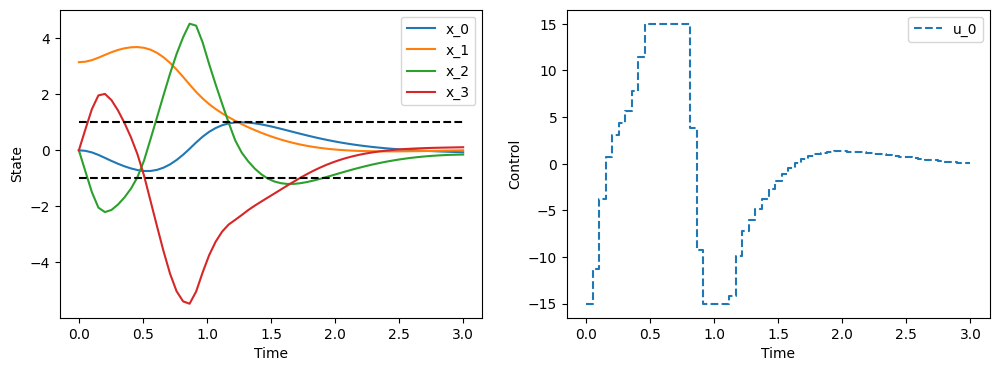

In [21]:
U = np.array(x0[nx*(K+1):]).reshape(K,nu)
X = np.array(x0[:nx*K]).reshape(K,nx)
t_eval = np.linspace(0,T,K)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
for k in range(nx):
    plt.plot(t_eval,X[:,k],label=f"x_{k}")
plt.legend()
plt.hlines(y=x_lb[0],xmin=0,xmax=T,colors="black", linestyle='dashed')
plt.hlines(y=x_ub[0],xmin=0,xmax=T,colors="black", linestyle='dashed')
plt.xlabel("Time")
plt.ylabel("State")


plt.subplot(1,2,2)
for k in range(nu):
    plt.step(t_eval,U[:,k],linestyle="--",label=f"u_{k}")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Control")

plt.savefig("images/chap6_multiple_shooting_cartpole.png")
plt.show()

# MPC

In [22]:
# S_single = make_nlp_single()
# S_multiple = make_nlp_multiple()

# t_span = [0,10]
# t_eval = np.arange(*t_span,dt)

# x_init = casadi.DM([0,np.pi,0,0]) # 初期値
# x0 = casadi.DM.zeros(total_single)

# I = make_integrator()

# X = [x_init]
# U = []
# x_current = x_init
# for t in t_eval:
#     u_opt,x0 = compute_optimal_control_single(S_single,x_current,x0)
#     x_current = I(x0=x_current,p=u_opt)["xf"]
#     X.append(x_current)
#     U.append(u_opt)

# X.pop()
# X = np.array(X).reshape(t_eval.size,nx)
# U = np.array(U).reshape(t_eval.size,nu)

# plt.figure(figsize=(12,4))

# plt.subplot(1,2,1)
# for k in range(nx):
#     plt.plot(t_eval,X[:,k],label=f"x_{k}")
# plt.legend()

# plt.subplot(1,2,2)
# for k in range(nu):
#     plt.step(t_eval,U[:,k],linestyle="--",label=f"u_{k}")
# plt.legend()

# plt.show()

In [23]:
# S_single = make_nlp_single()
# S_multiple = make_nlp_multiple()

# t_span = [0,10]
# t_eval = np.arange(*t_span,dt)

# x_init = casadi.DM([0,np.pi,0,0]) # 初期値
# x0 = casadi.DM.zeros(total_multiple)

# I = make_integrator()

# X = [x_init]
# U = []
# x_current = x_init
# for t in t_eval:
#     u_opt,x0 = compute_optimal_control_multiple(S_multiple,x_current,x0)
#     x_current = I(x0=x_current,p=u_opt)["xf"]
#     X.append(x_current)
#     U.append(u_opt)

# X.pop()
# X = np.array(X).reshape(t_eval.size,nx)
# U = np.array(U).reshape(t_eval.size,nu)

# plt.figure(figsize=(12,4))

# plt.subplot(1,2,1)
# for k in range(nx):
#     plt.plot(t_eval,X[:,k],label=f"x_{k}")
# plt.legend()

# plt.subplot(1,2,2)
# for k in range(nu):
#     plt.step(t_eval,U[:,k],linestyle="--",label=f"u_{k}")
# plt.legend()

# plt.show()